In [1]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds

import matplotlib.pyplot as plt
import numpy as np

# set random seed
np.random.seed(42)

import corner

In [34]:
from scipy.stats import rv_continuous
class CosineLatitudeDist(rv_continuous):
    def _pdf(self, beta):
        # Support: beta in [-pi/2, pi/2]
        return 0.5 * np.cos(beta)

    def logpdf(self, beta):
        return np.log(0.5) + np.log(np.cos(beta))

    def rvs(self, size=None, random_state=None):
        # Inverse transform sampling
        u = np.random.uniform(-1, 1, size=size)
        return np.arcsin(u)  # since sin(beta) ~ U(-1, 1)

# Instantiate the distribution
cosine_latitude = CosineLatitudeDist(a=-np.pi/2, b=np.pi/2)


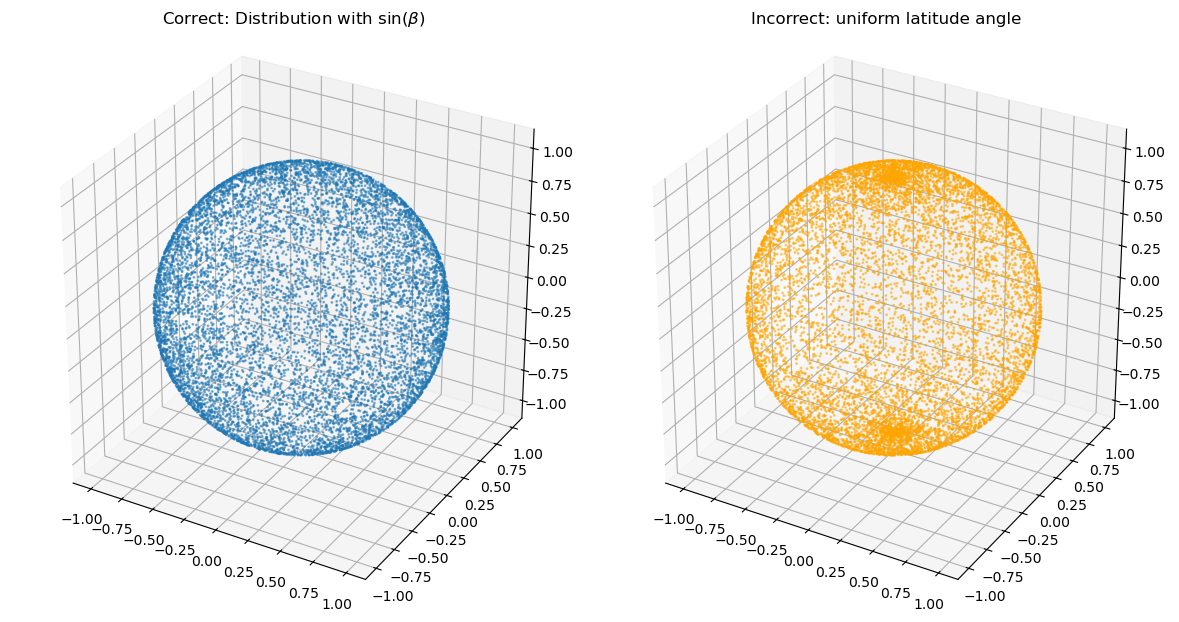

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n = 10000

# Cosine-weighted beta (correct)
beta_1 = cosine_latitude.rvs(size=n)
lam_1 = np.random.uniform(0, 2 * np.pi, size=n)
x1 = np.cos(beta_1) * np.cos(lam_1)
y1 = np.cos(beta_1) * np.sin(lam_1)
z1 = np.sin(beta_1)

# Uniform beta (wrong for area)
beta_2 = np.random.uniform(-np.pi/2, np.pi/2, size=n)
lam_2 = np.random.uniform(0, 2 * np.pi, size=n)
x2 = np.cos(beta_2) * np.cos(lam_2)
y2 = np.cos(beta_2) * np.sin(lam_2)
z2 = np.sin(beta_2)

# Plot both
fig = plt.figure(figsize=(12, 6))

# Proper sampling
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, y1, z1, s=1, alpha=0.5)
plt.title(r'Correct: Distribution with $\sin(\beta)$')
ax1.set_box_aspect([1, 1, 1])

# Uniform angle sampling
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x2, y2, z2, s=1, alpha=0.5, color='orange')
ax2.set_title("Incorrect: uniform latitude angle")
ax2.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()


In [32]:
cosine_latitude

In [33]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(0.0, 2 * np.pi),
    1: uniform_dist(-np.pi/2, np.pi/2),
    2: CosineLatitudeDist(-np.pi/2, np.pi/2),
})}

In [ ]:
priors["mbh"]

{0: <eryn.prior.UniformDistribution at 0x16a1c7710>,
 1: <eryn.prior.UniformDistribution at 0x16a1c5280>,
 2: <__main__.CosineLatitudeDist at 0x16a1c7b60>}

# What even is an MCMC?
MCMC is really just a way to draw samples from a distribution. When the distribution is simple like in the following example, it will usually be available already with no need to run MCMC. However, in GWs, the Likelihood distribution tends to be very difficult to deal with, which is why MCMC is so useful.

In the following example, the likelihood is just $ e^{x^2} $. The key thing is that we know this simple form of the distribution and we immediately know that $x=0$ will give us the maximum liklihood. But in LISA GWs, the likelihood function is $ e^{ 0.5 <d-h(\theta) | d-h(\theta) > } $ , where $\theta = \vec\theta$ has $12$ dimensions. Good luck finding the maxima of that function, i.e., the values of $\theta_{TRUE}$. 

Here is where MCMC comes to our rescue. The best thing we can do is pick a random starting point and try to navigate this forest to get close to the maxima. And also, we care about uncertainties. Hence, the task is not just "finding the maxima", but drawing samples hopefully close to the maxima and making a posterior distribution of the 12 input parameters.

My best analogy: Think of a blind person standing at the entrance of Zürich HB trying to find the peak of Uetliberg. I haven't found any analogies with a blind person, but I think it illustrates the idea perfectly.
- The input variables are x and y (two dimensions confined to the city of Zürich)
- The prior on x and y correspond to the size of Zürich. Assume it's a square of 20 km. 
- The proposal function is walking 10 meters along a direction picked from a uniform distribution between $[0,2\pi)$
- The liklihood function is just the height of every point, which the blind person can calculate based on the effort they had to put to go to the new point.

Suppose we have a 5 dimensional gaussian likelihood with the mean = zero and a 5 dimensional Identity matrix as its covariance matrix. Remember, the task is not "finding $\mu$ and the covariance matrix". I always thought that this was the task and I got super confused. The task is simply drawing samples from the likelihood function close to $\mu$. Keep this at the back of your mind always.

In [2]:
# Gaussian log likelihood
def log_like_fn(x, mu, invcov):
    diff = x - mu
    return -0.5 * (diff * np.dot(invcov, diff.T).T).sum()

In [3]:
# number of dimensions, used in eryn
ndim = 5

# means and covariance matrix for the likelihood
means = np.zeros(ndim)
cov = np.diag(np.ones(ndim))
invcov = np.linalg.inv(cov)

In [4]:
# Defining the priors as a uniform distribution in a 5D box around the means with a width of means[i] ± lims
lims = 5.0
priors_in = {i: uniform_dist(-lims + means[i], lims + means[i]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)

In [5]:
nwalkers = 100
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    priors,
    args=[means, invcov],
)

In [6]:
# starting positions
# randomize throughout prior
coords = priors.rvs(size=(nwalkers,))

# check log_like
log_like = np.asarray([
    log_like_fn(coords[i], means, invcov)
for i in range(nwalkers)])
#print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = np.asarray([
    priors.logpdf(coords[i])
for i in range(nwalkers)])
#print("\nLog-prior:\n", log_prior)

In [7]:
nsteps = 500
# burn for 1000 steps
burn = 100
# thin by 5
thin_by = 5
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

100%|██████████| 2500/2500 [00:03<00:00, 768.98it/s]


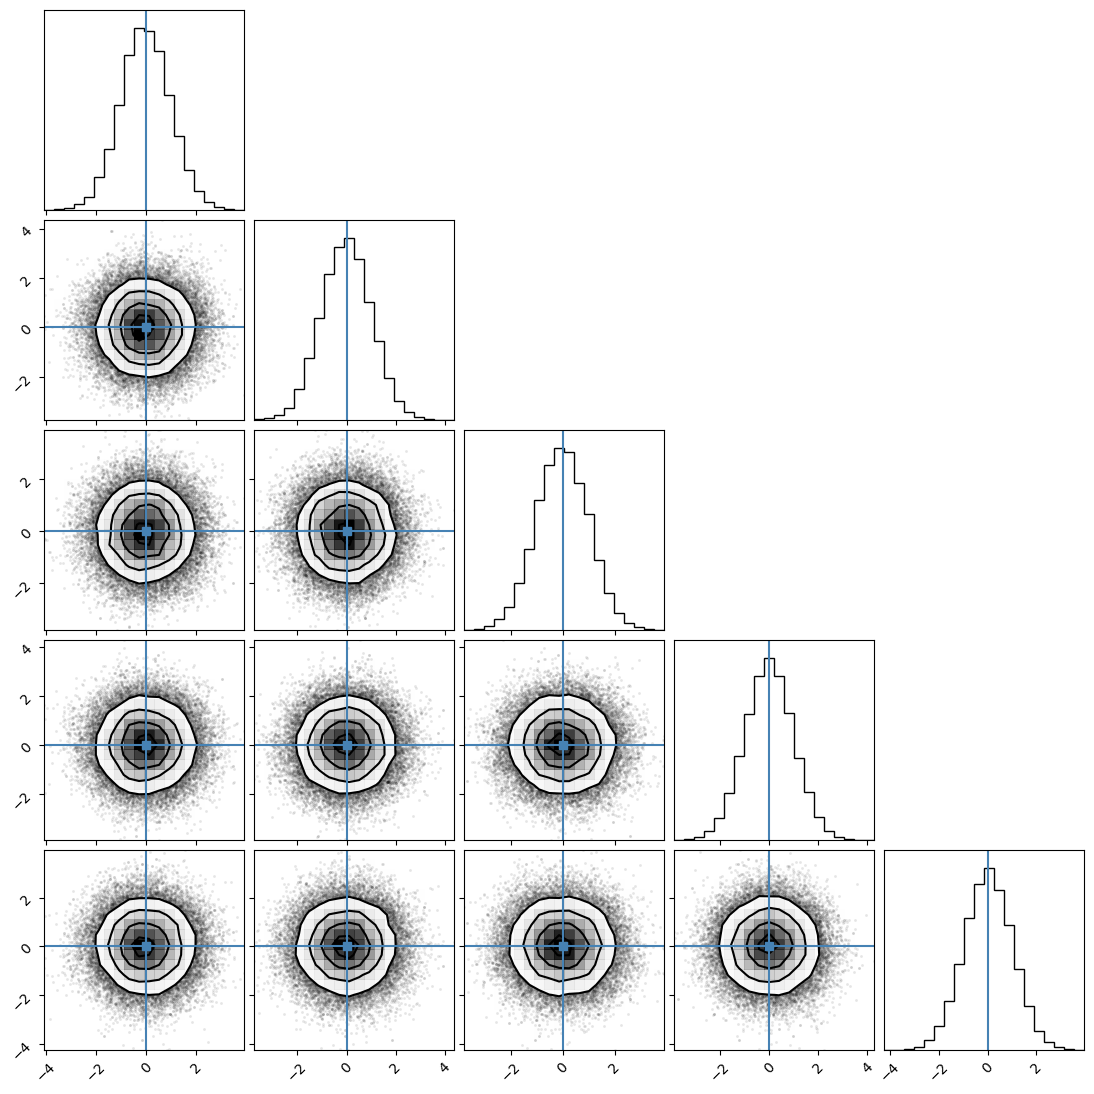

In [8]:
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner.corner(samples, truths=means);


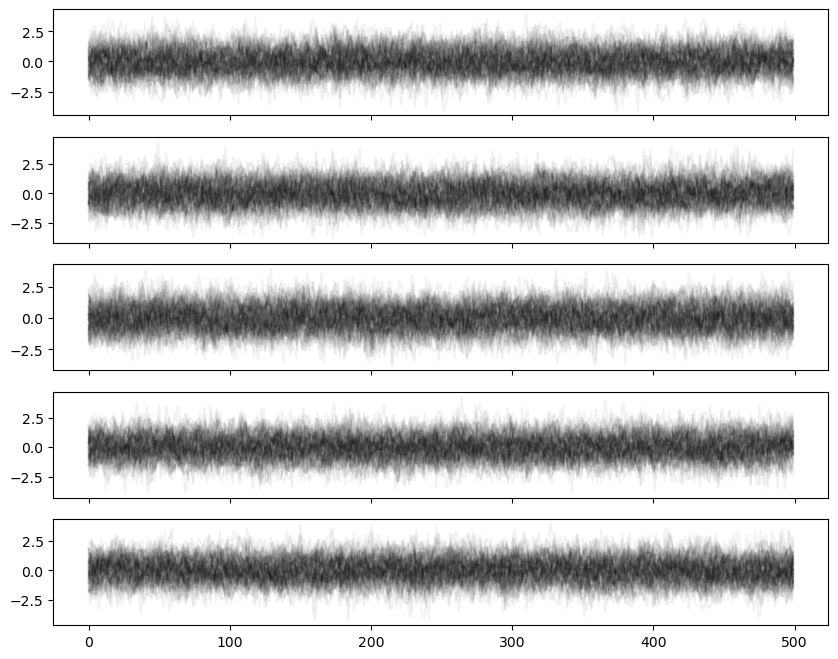

In [9]:
#### Chains
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.05)


In [10]:
ll = ensemble.backend.get_log_like()
lp = ensemble.backend.get_log_prior()

print(f"Number of iterations {ensemble.backend.iteration}\n")
# equivalent to ensemble.get_log_like() and ensemble.get_log_prior()
print(ll.shape, ll, lp)


Number of iterations 500

(500, 1, 100) [[[-1.05297225 -2.81695595 -0.80839791 ... -1.30449907 -2.65001331
   -1.72492908]]

 [[-3.51878996 -0.89787788 -4.49356178 ... -4.65518146 -3.7436319
   -1.66068016]]

 [[-2.03059694 -1.49585829 -3.90577462 ... -1.04656098 -2.0396035
   -0.80658449]]

 ...

 [[-1.73887276 -2.27535667 -1.36789573 ... -1.19099689 -2.72232295
   -5.43958501]]

 [[-1.44427868 -1.05581352 -4.30749439 ... -1.85688564 -2.11343788
   -2.24766066]]

 [[-0.6654815  -2.28154314 -2.00102494 ... -1.6139005  -1.08899932
   -2.1398411 ]]] [[[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 ...

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -

In [11]:
# getting the chain
samples = ensemble.get_chain()

# same as
# samples = enseble.backend.get_chain()
print(type(samples), samples.keys(), samples["model_0"].shape)

<class 'dict'> dict_keys(['model_0']) (500, 1, 100, 1, 5)


In [12]:
ensemble.backend.shape

{'model_0': (1, 100, 1, 5)}

In [13]:
last_state = ensemble.backend.get_last_sample()
print(type(last_state))

<class 'eryn.state.State'>


In [14]:
print(out.log_like.shape)
print(out.log_like)
print(out.log_prior)
print(out.get_log_posterior())


(1, 100)
[[-0.6654815  -2.28154314 -2.00102494 -4.41852808 -1.87391204 -3.05035603
  -1.47197889 -3.04722716 -3.8519063  -2.53028792 -1.47895075 -0.91435392
  -4.67615627 -6.59494035 -3.09579563 -2.31956089 -3.61486196 -1.12447462
  -2.1692713  -4.54813706 -5.47761491 -1.81600973 -2.57141612 -3.18369399
  -8.03114163 -4.03929851 -1.37835437 -1.41370852 -2.04192051 -4.24060107
  -1.81791365 -1.43145056 -1.01976309 -1.08419629 -3.29498179 -2.08090042
  -3.03457142 -0.97839311 -1.45783438 -0.54860516 -0.39096809 -1.63453914
  -2.05034555 -1.13275529 -2.13057916 -3.21847262 -2.14804885 -2.15556008
  -1.92686111 -1.99795709 -0.35164059 -1.21098077 -1.21647944 -1.15304968
  -3.4313149  -4.70693915 -1.4318716  -4.84488379 -2.02338003 -2.07328961
  -2.98861309 -1.0448529  -4.76536477 -1.86707428 -1.24040534 -1.52161672
  -0.93361207 -1.10290796 -1.69669336 -0.98189704 -5.90223547 -3.3408396
  -2.12094704 -3.14709346 -0.37990706 -1.48720061 -3.15361028 -1.1595534
  -1.80055637 -1.59197714 -3.34

In [15]:
last_state.branches

{'model_0': <eryn.state.Branch at 0x15ab5ddc0>}

In [16]:
last_state.branches["model_0"].coords

# same as
# last_state.branches_coords["model_0"]


array([[[[ 0.78336101, -0.50304083, -0.16554043,  0.38717246,
          -0.53567929]],

        [[ 1.67992539,  0.45789611,  0.71044046,  0.99561671,
          -0.18785587]],

        [[ 1.58942687, -0.98468048, -0.23409897, -0.34754982,
           0.5749637 ]],

        [[-1.51043746,  1.46761376, -1.36652826,  0.13575554,
           1.58616381]],

        [[ 0.56687718, -0.71412812, -1.07272873,  0.90290266,
          -0.9749437 ]],

        [[-0.26148892, -0.32754323,  2.05336273,  0.43505825,
           1.23267062]],

        [[-0.11388586,  0.97965383,  1.18803374, -0.55536628,
           0.50140833]],

        [[ 0.97231495, -1.80168105, -0.87750463,  0.55941876,
           0.9055604 ]],

        [[ 0.93206222,  0.61099548,  0.22893838, -0.06397951,
           2.53085973]],

        [[ 1.78123828,  0.29397075,  0.87720694, -0.51235873,
          -0.87712242]],

        [[-0.0915609 , -0.06094217,  0.39300579,  0.27838045,
          -1.6473782 ]],

        [[ 0.6848448 ,  0.373946

In [17]:

# set up problem
ndim = 5
nwalkers = 100
ntemps = 10

# fill kwargs dictionary
tempering_kwargs=dict(ntemps=ntemps)

# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))

# initialize sampler
ensemble_pt = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    priors,
    args=[means, cov],
    tempering_kwargs=tempering_kwargs
)

nsteps = 500
# burn for 1000 steps
burn = 1000
# thin by 5
thin_by = 5
ensemble_pt.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

100%|██████████| 2500/2500 [00:15<00:00, 166.21it/s]


1
2
3
4
5
6
7
8
9
10


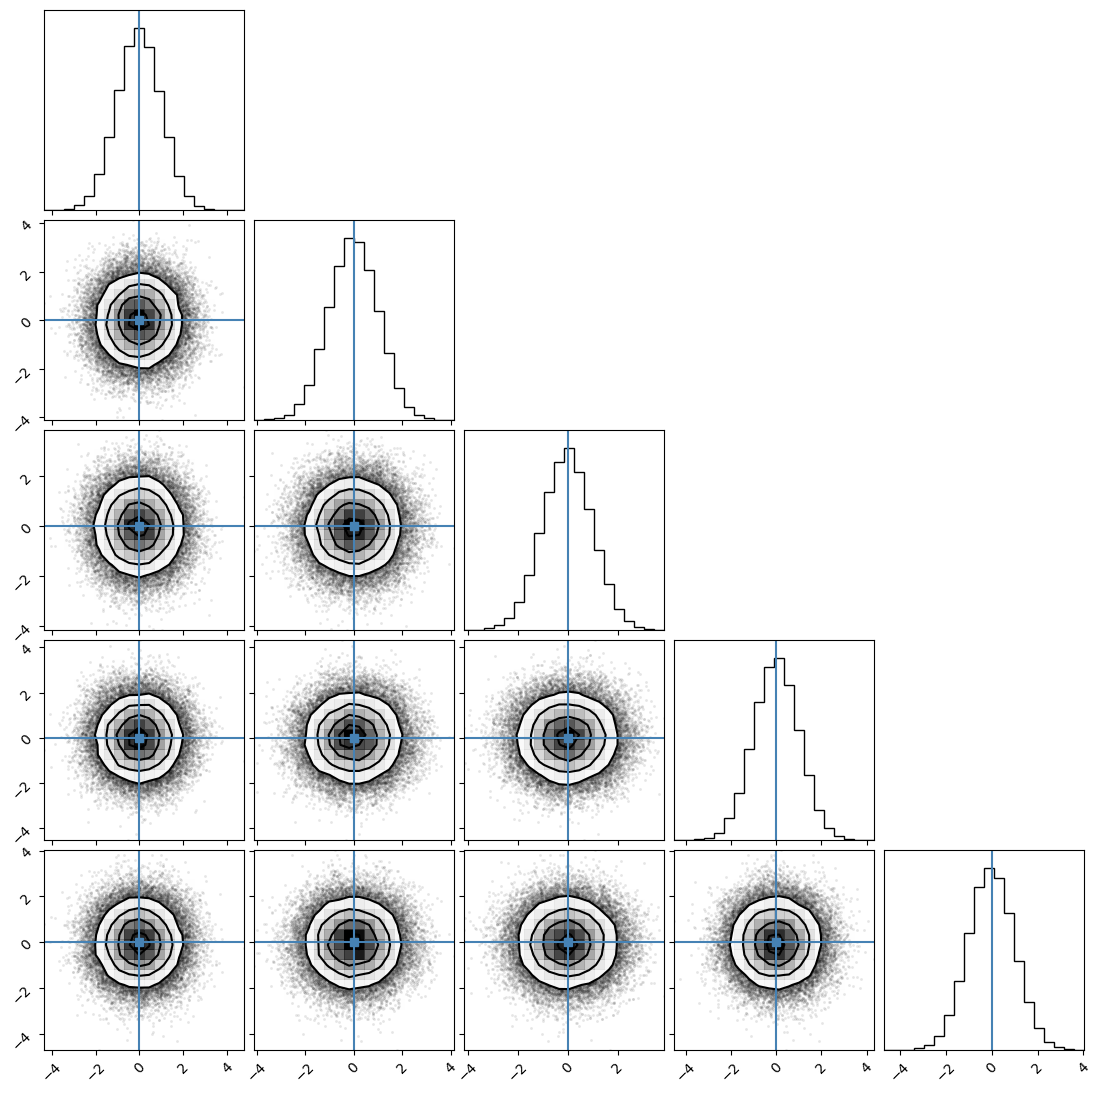

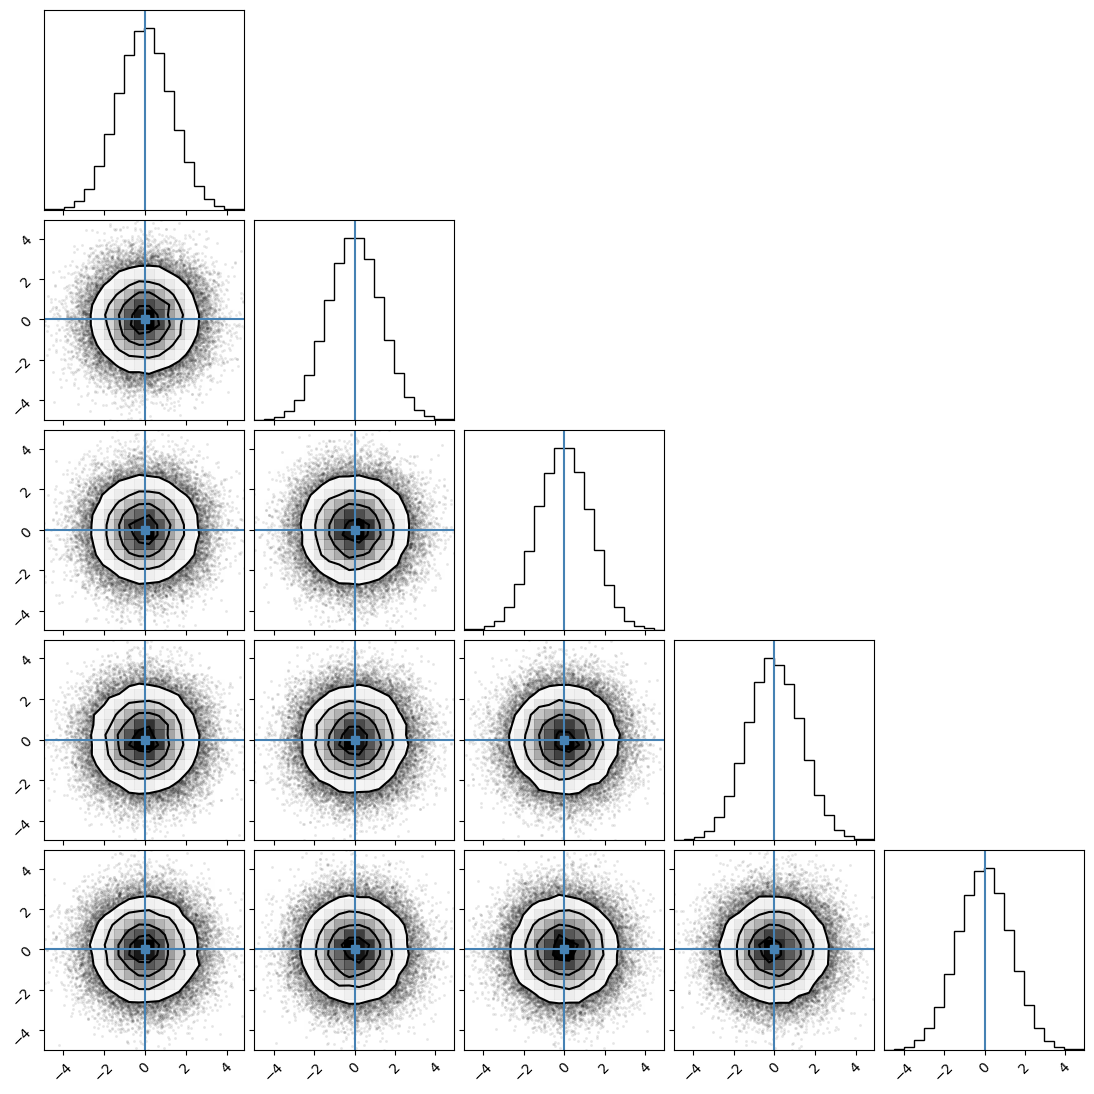

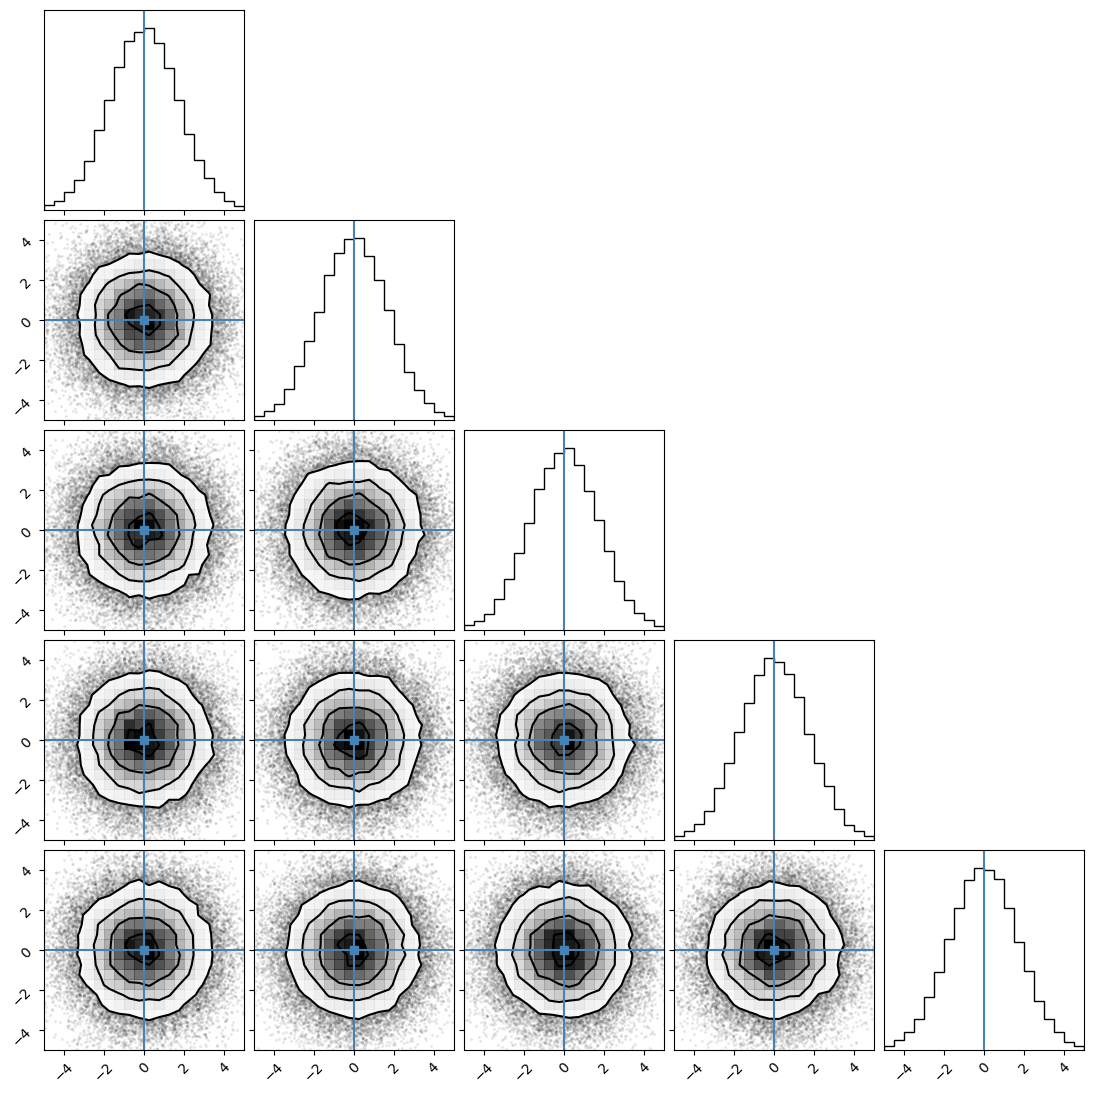

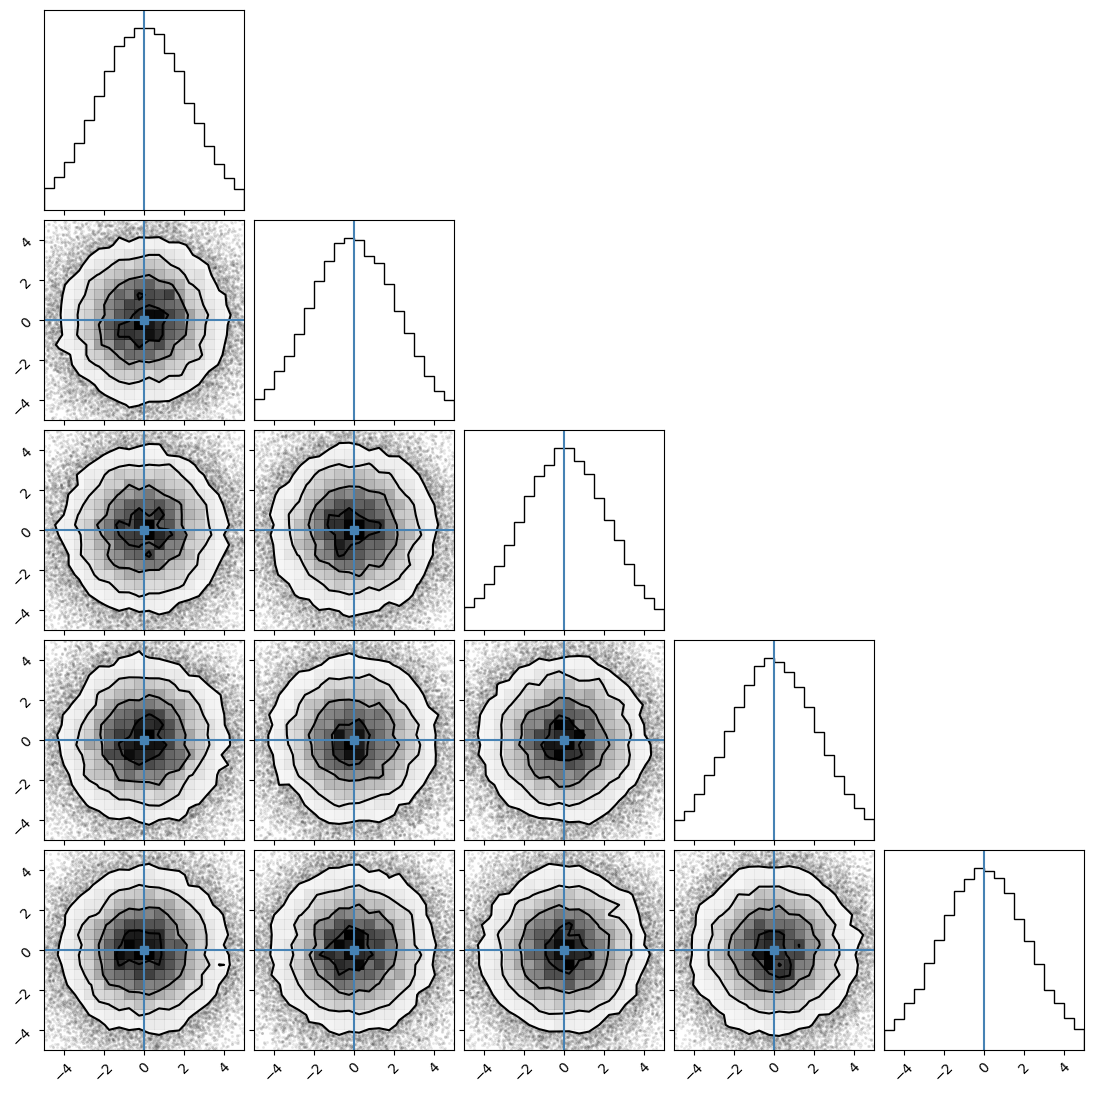

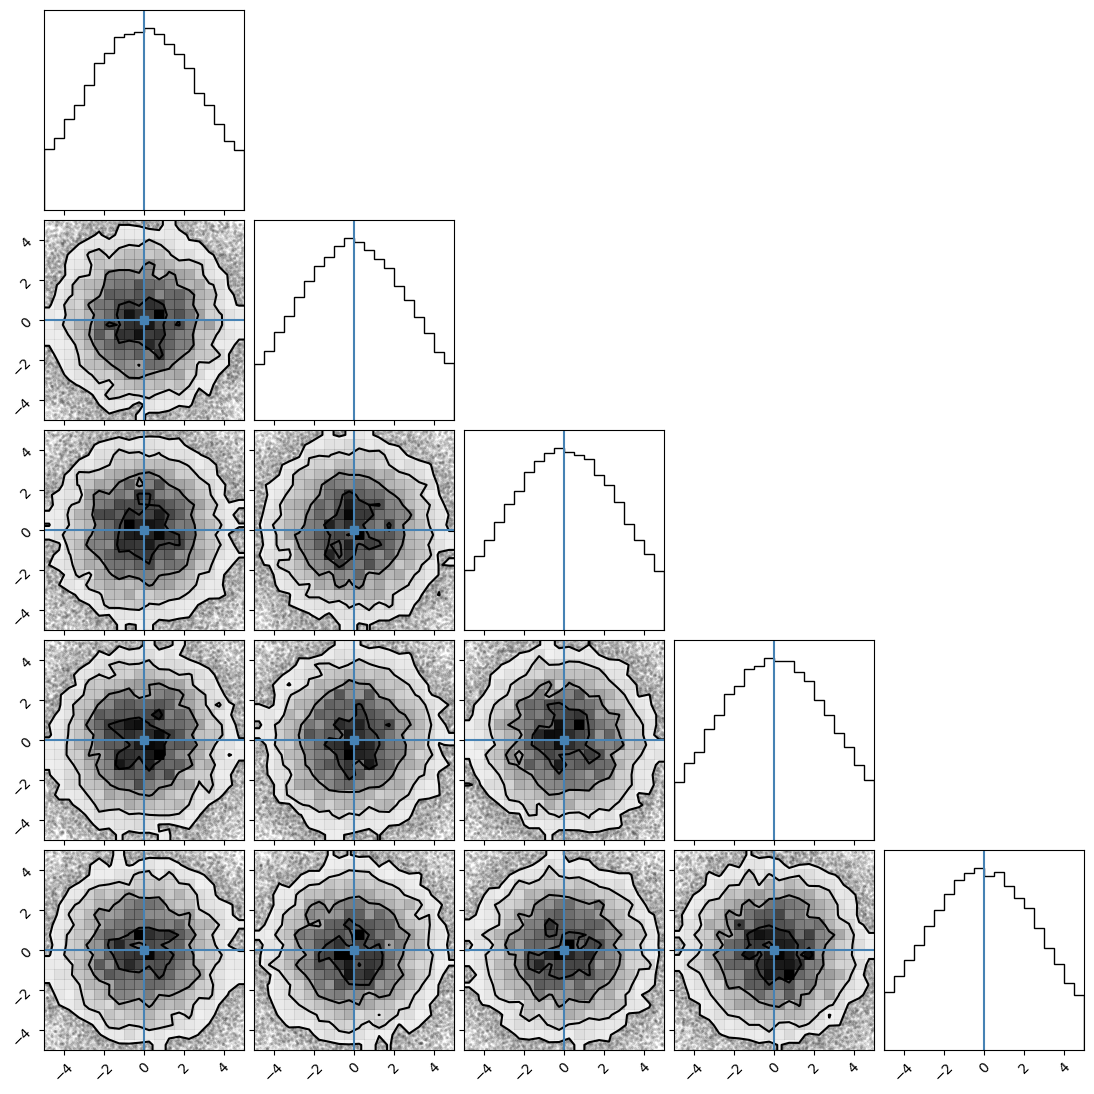

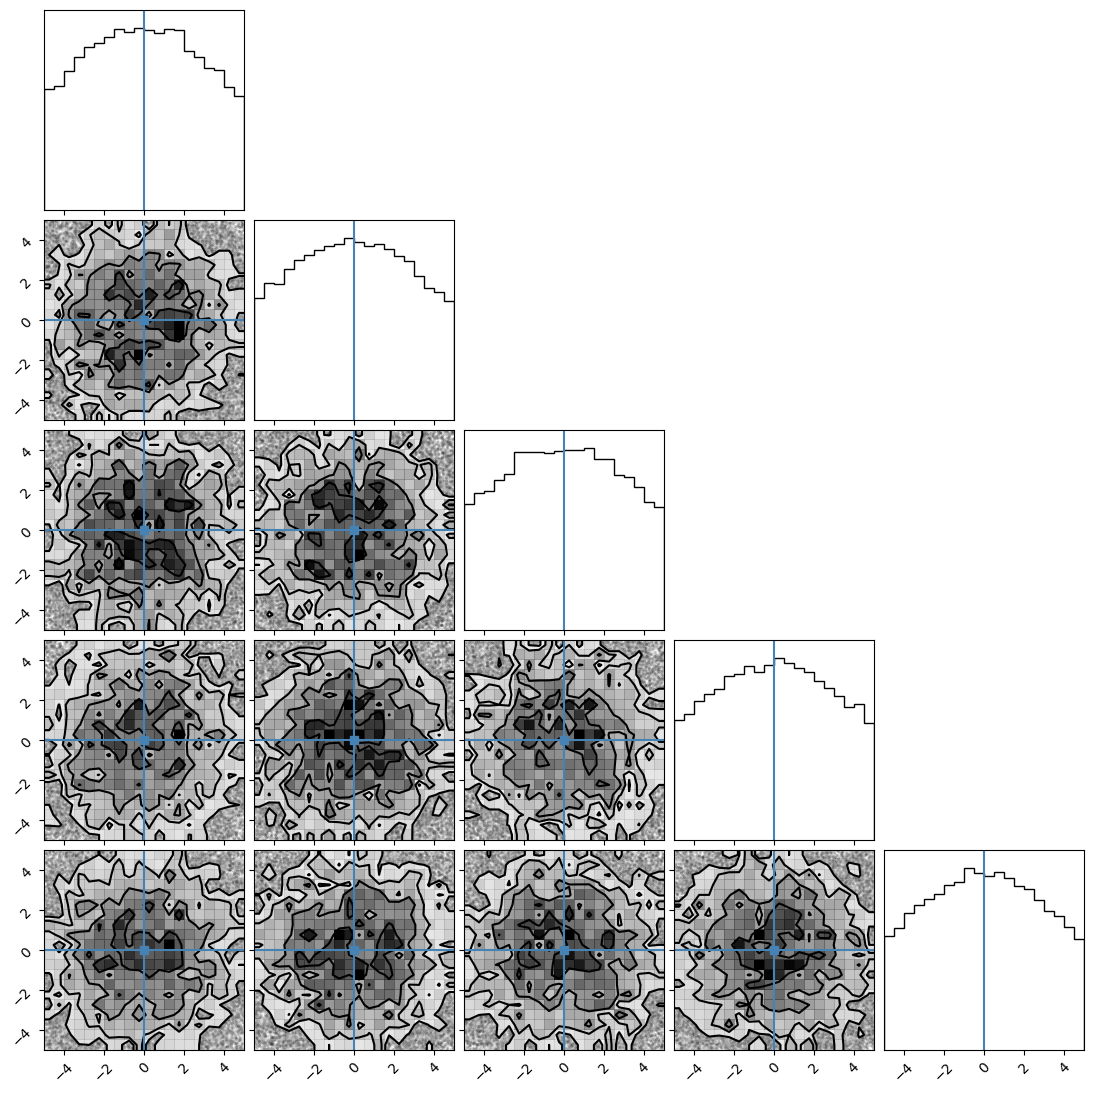

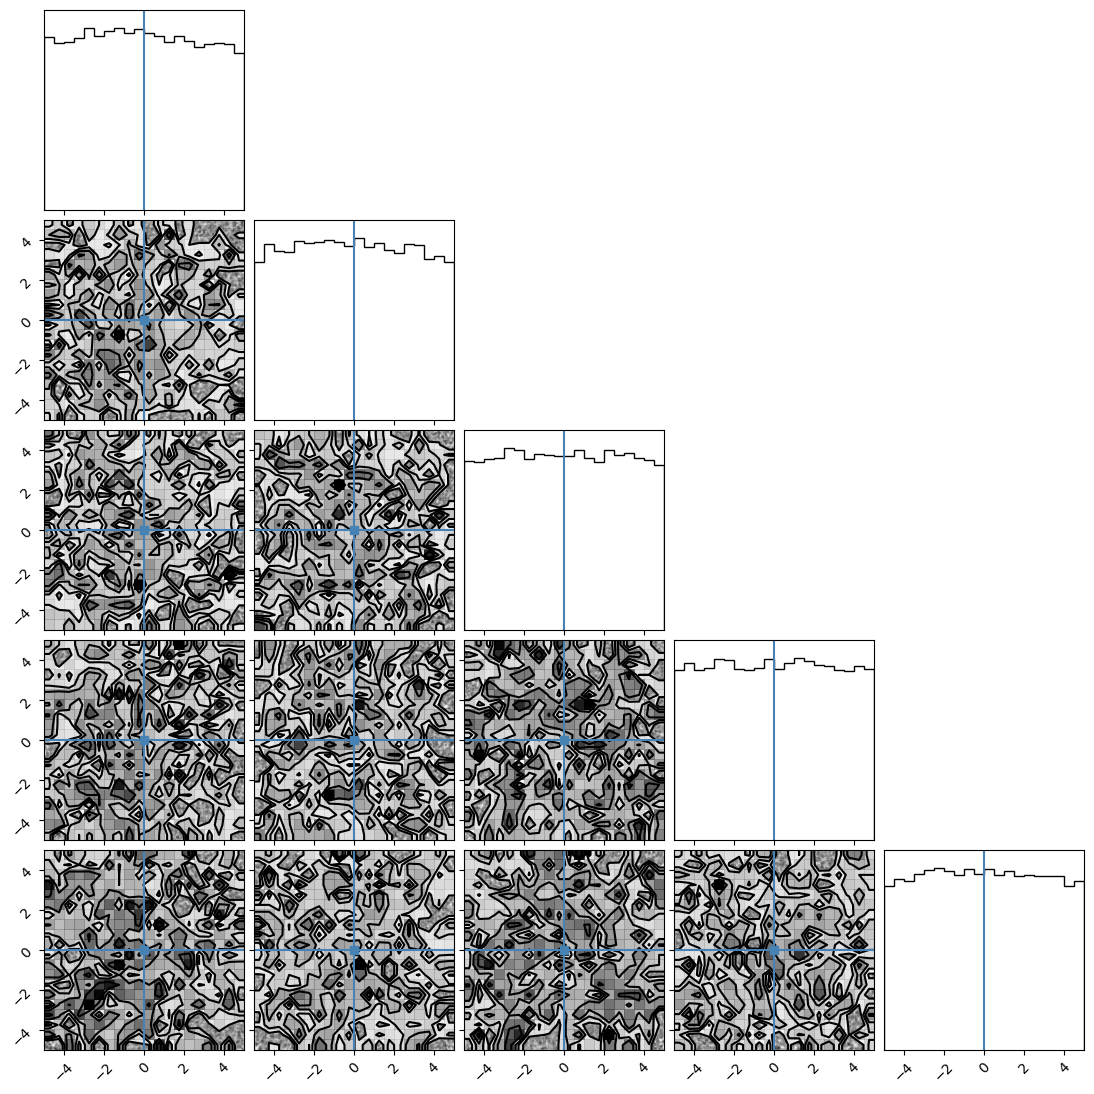

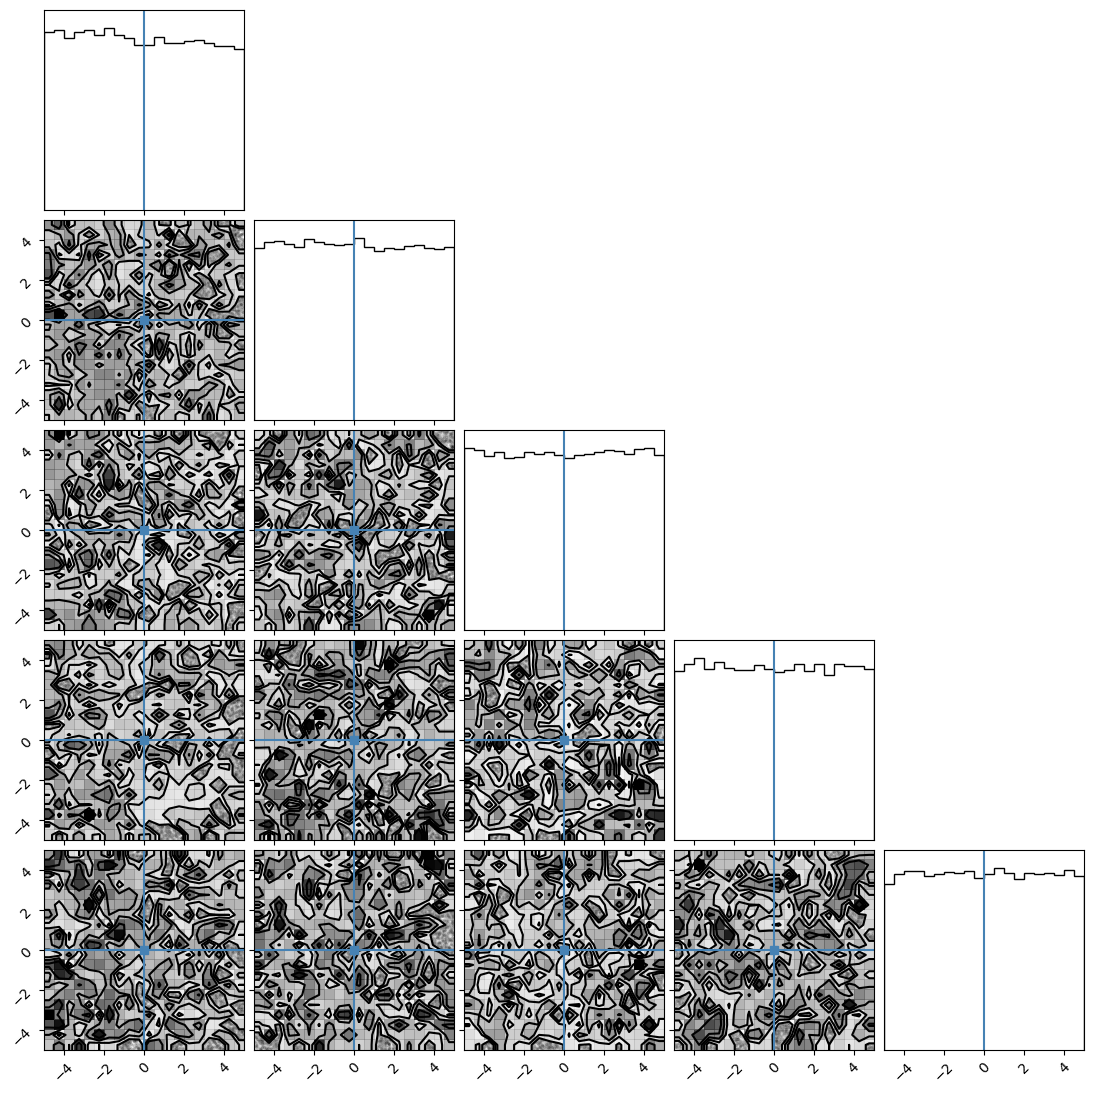

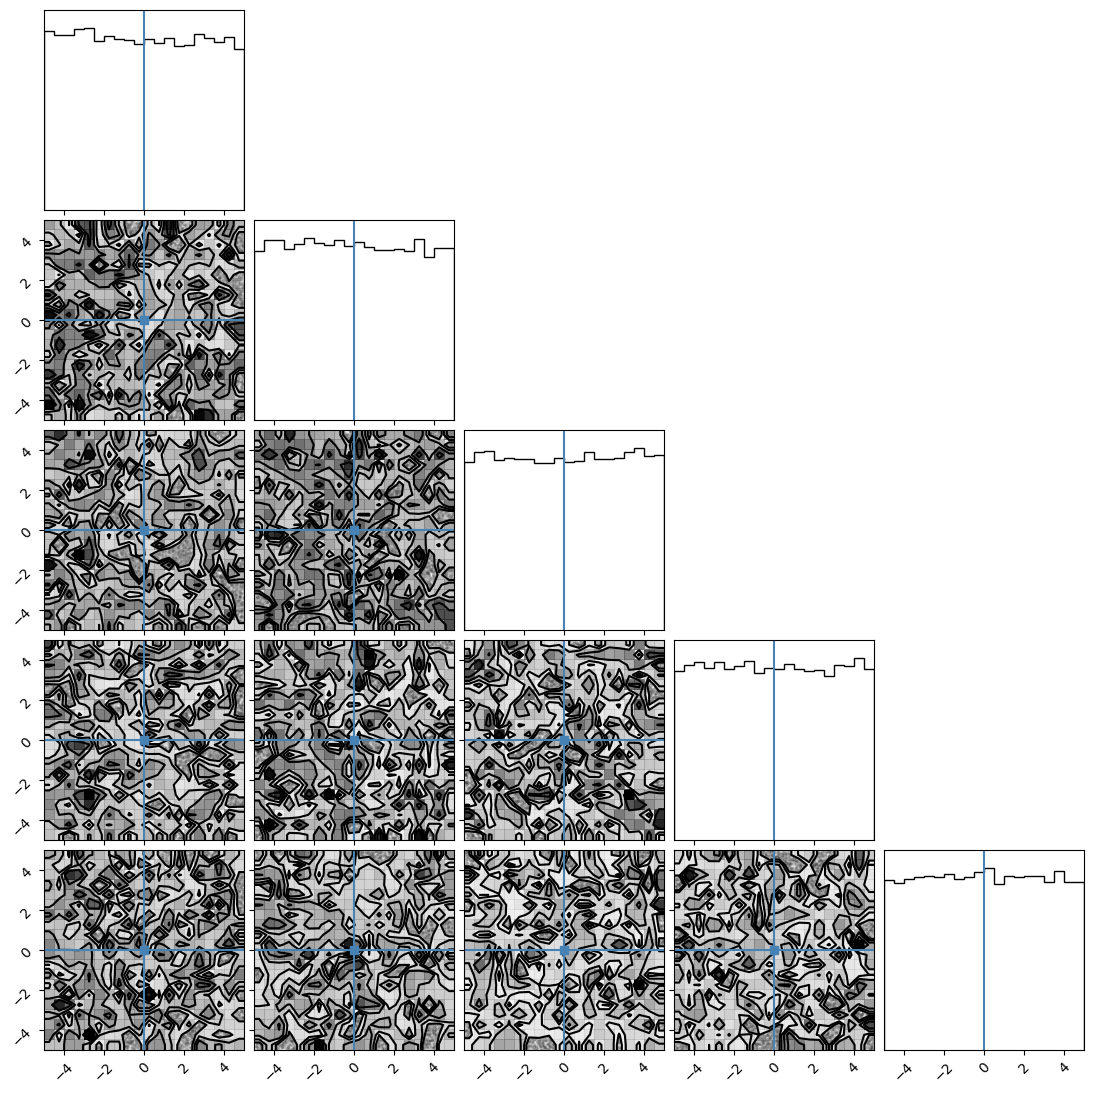

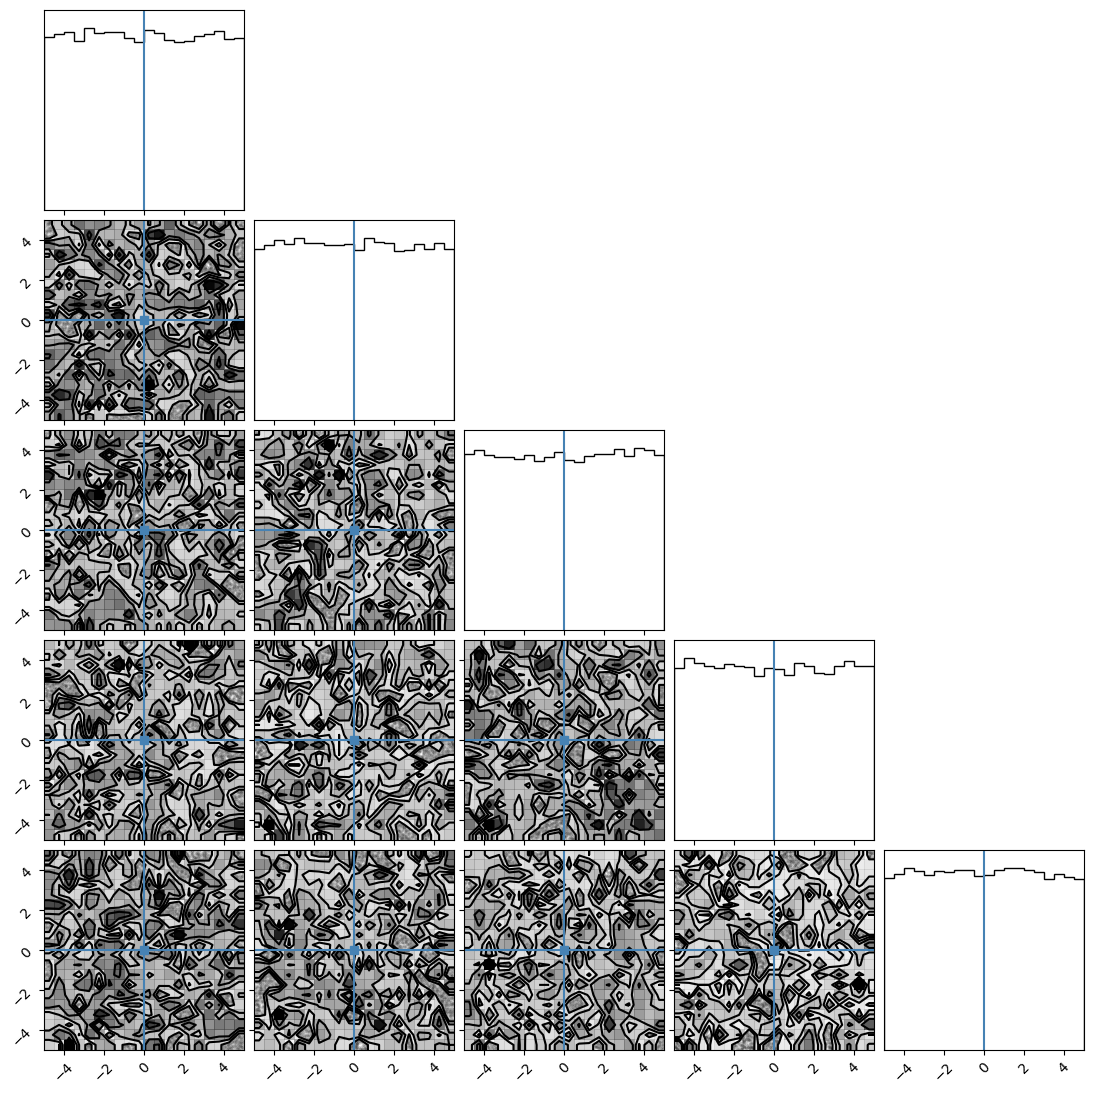

In [18]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble_pt.get_chain()['model_0'][:, temp].reshape(-1, ndim)
    corner.corner(samples, truths=np.full(ndim, 0.0))


(500, 10, 100)


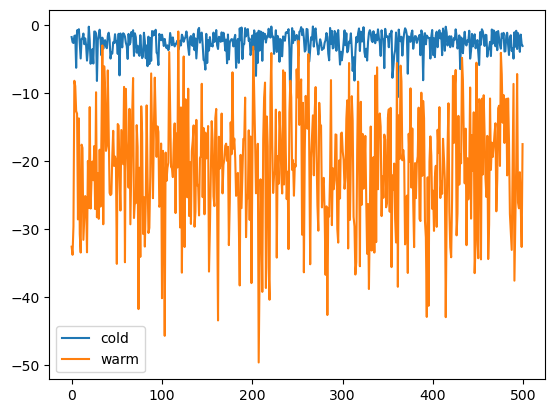

In [19]:
ll = ensemble_pt.backend.get_log_like()
print(ll.shape)

# cold chain and highest temperature chain
plt.plot(ll[:, 0, 0], label="cold")
plt.plot(ll[:, -1, 0], label="warm")
plt.legend();
